In [11]:
#Include file containing functions and fundamental constants
include("helpers.jl")

prop_system (generic function with 1 method)

In [2]:
λ_center = 1560e-9;
ω_center = 2*pi*c_light / λ_center;
fiber_index = 1.47;
v_group = c_light / fiber_index;
fiber_dispersion = 1*22e3 * 1e-30 * v_group^3; # in m^2/s
γ_fiber = 1.8*1e-3; # in 1/W/m.
fiber_nonlinearity = ħ*(ω_center)*(v_group^2)*(γ_fiber);
L_fiber = 10; # in meters
T_fiber = L_fiber / v_group;

# Pulse parameters - pulse time only makes sense for single-parameter pulses like sech / gaussian
t_pulse = 100e-15; # in seconds
L_pulse = v_group * t_pulse;

L_sim = 50*L_pulse;
N_z = 2^8;
z_grid = collect(range(-L_sim/2,L_sim/2,length=N_z));

N_t = 200;
dt = T_fiber / N_t;
t_grid = collect(range(0,T_fiber,length=N_t));

In [13]:
sim_fbs = sim(2,2^8,z_grid)

power_list = [0.01:0.08:2.5;]*1e8
t_list = [0:0.015:0.3;]

println(length(power_list))
println(length(t_list))
println("estimated time(min): ", length(t_list) * length(power_list) * 1.5)

photons_in = zeros(length(power_list), length(t_list));
photons_out = zeros(length(power_list), length(t_list),sim_fbs.num_modes);
photons_fluc = 1.0im*zeros(length(power_list), length(t_list),sim_fbs.num_modes);

V_vac = vacuum_V(sim_fbs);

function power_loop(ii)
    for jj=1:length(t_list)
        println(ii)
        println(jj)
        println("(thread $(Threads.threadid()) of out $(Threads.nthreads()))")

        bs1 = beamsplitter([1,2],sqrt(t_list[jj]));
        fiber1 = fiber(1,fiber_index,L_fiber,fiber_dispersion,fiber_nonlinearity);
        fiber2 = fiber(2,fiber_index,L_fiber,fiber_dispersion,fiber_nonlinearity);
        bs2 = beamsplitter([1,2],sqrt(t_list[jj]));

        components = [bs1 fiber1 fiber2 bs2];

        # Initializing the mean fields of the initial state
        center_amplitude = sqrt(power_list[ii]);
        state_sagnac = state(1.0im*zeros((sim_fbs.num_modes)*(sim_fbs.N_z)),V_vac);
        range_mode1 = get_row_index(1,fiber1.fiber_mode):get_row_index(N_z,fiber1.fiber_mode);
        state_sagnac.mean_fields[range_mode1] .= center_amplitude * sech.(sim_fbs.z_grid/L_pulse);
        photons_in[ii,jj] = sum(abs2.(get_meanfield_i(state_sagnac,1)));

        # Solving for mean-field and fluctuation dynamics
        prop_system(components,state_sagnac,sim_fbs,t_grid);

        for ss=1:sim_fbs.num_modes
            photons_out[ii,jj,ss] = sum(abs2.(get_meanfield_i(state_sagnac,ss)));
            photons_fluc[ii,jj,ss] = n2_exp(state_sagnac,ss,sim_fbs);
        end

    end
    
end

Folds.map(power_loop, 1:length(power_list))

25
21
estimated time(min): 787.5
1
1
(thread 1 of out 1)
1


LoadError: InterruptException:

In [4]:
squeezing_sing = 10log10.(photons_fluc ./ photons_out);

(2, 4, 2)


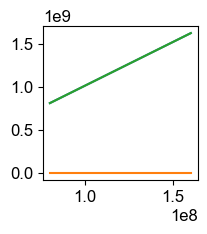

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005A91C130>

In [5]:
println(size(photons_out))
PyPlot.plot(power_list, photons_out[:,1,1])
PyPlot.plot(power_list, photons_out[:,1,2])
PyPlot.plot(power_list, photons_out[:,1,1]+photons_out[:,1,2])

C:\Users\Devin Seyler\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


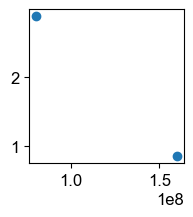

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000060183220>

In [6]:
PyPlot.plot(power_list, squeezing_sing[:,2,1], "o")

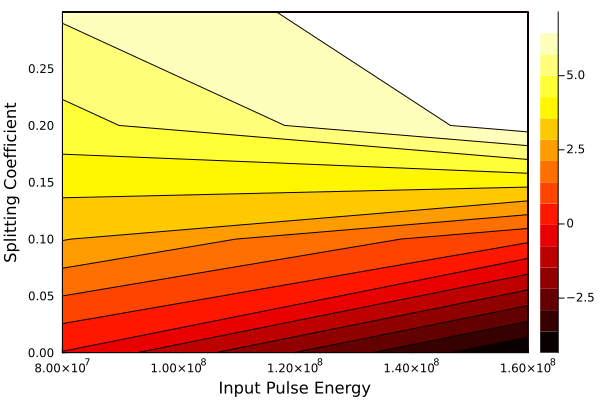

In [12]:

x = power_list
y = t_list
function f(x,y)
    x_sqrt = x
    y_sqrt = y
    x_diff =power_list[2] - power_list[1]
    y_diff = t_list[2] - t_list[1]
    x_i = round(Int, (x_sqrt - power_list[1])/x_diff) + 1
    y_i = round(Int, (y_sqrt - t_list[1])/y_diff) + 1
    #println(x_i)
    #println(y_i)
    return real(squeezing_sing[x_i,y_i,1])
end

Plots.contour(x, y, f, fill=true, c=cgrad(:hot))
Plots.xlabel!("Input Pulse Energy")
Plots.ylabel!("Splitting Coefficient")